# Visualizing what CNN see

In [1]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')

Q:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

(1, 150, 150, 3)


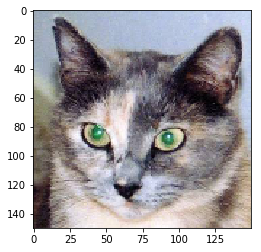

In [14]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
img_path = "D:\\Python\\Keras\\cat_dog\\train\\cat.1700.jpg"
import numpy as np
img = image.load_img(img_path, target_size=(150, 150))

img_tensor = image.img_to_array(img)
img_tensor /= 255.
plt.imshow(img_tensor)
img_tensor = np.expand_dims(img_tensor, axis=0)
print(img_tensor.shape)

In [4]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

(1, 148, 148, 32)


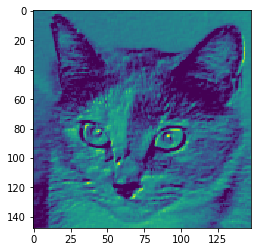

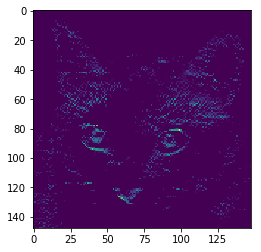

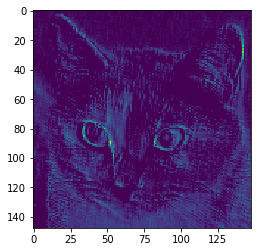

In [12]:
import matplotlib.pyplot as plt
first_layer_activation = activations[0]
print(first_layer_activation.shape)
for i in range(3):
    plt.figure()
    plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')

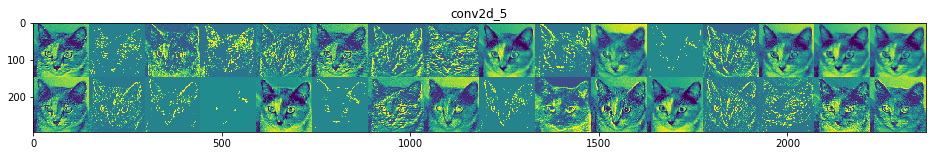

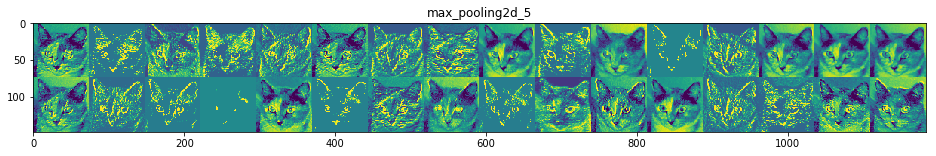

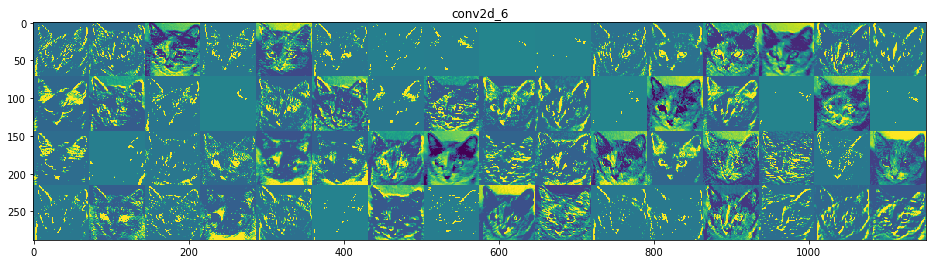

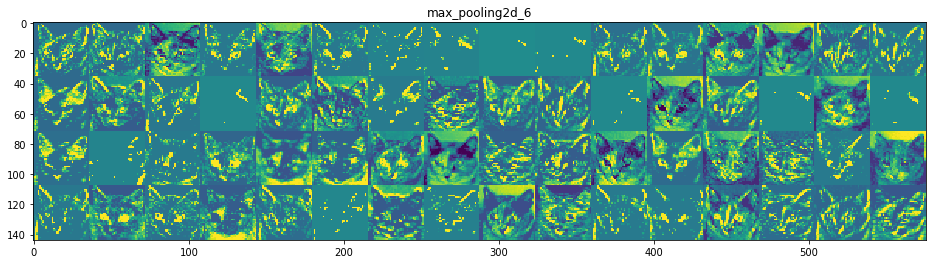

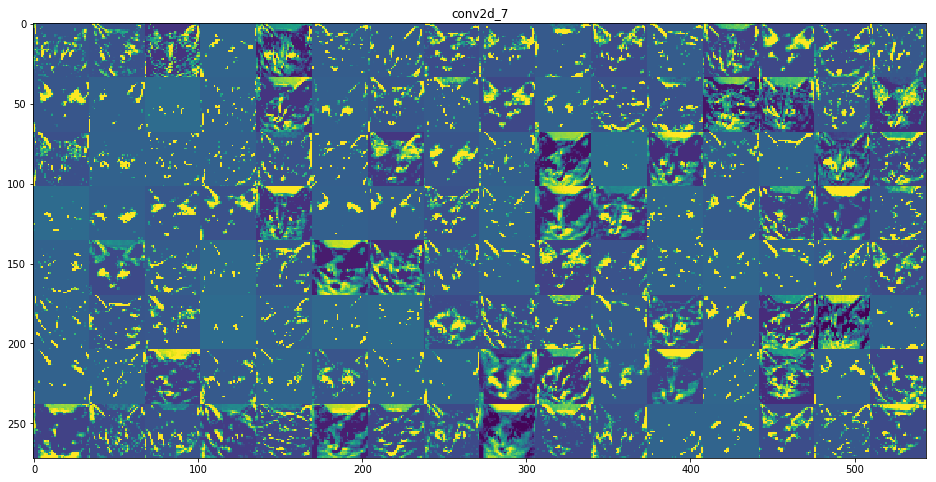

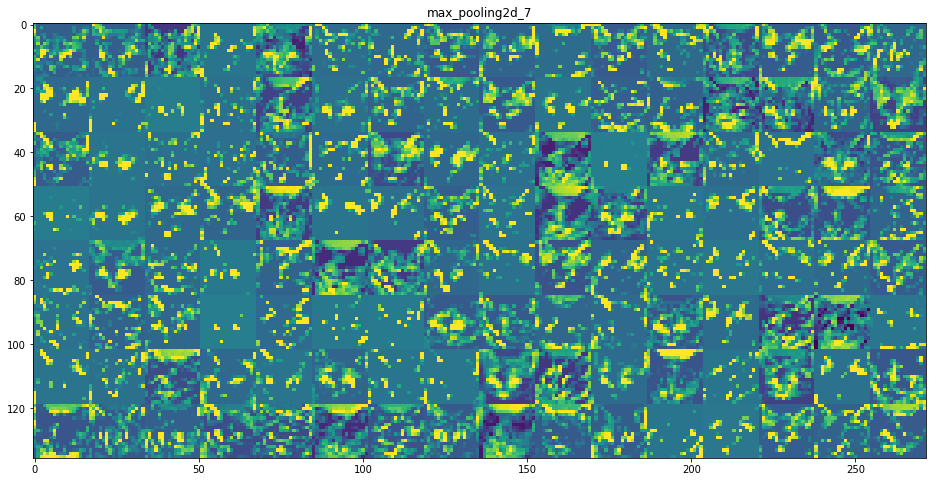

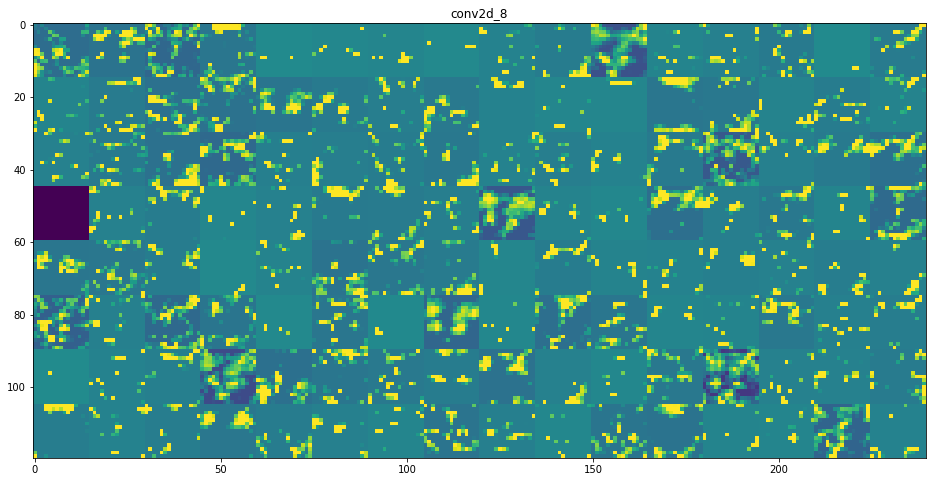

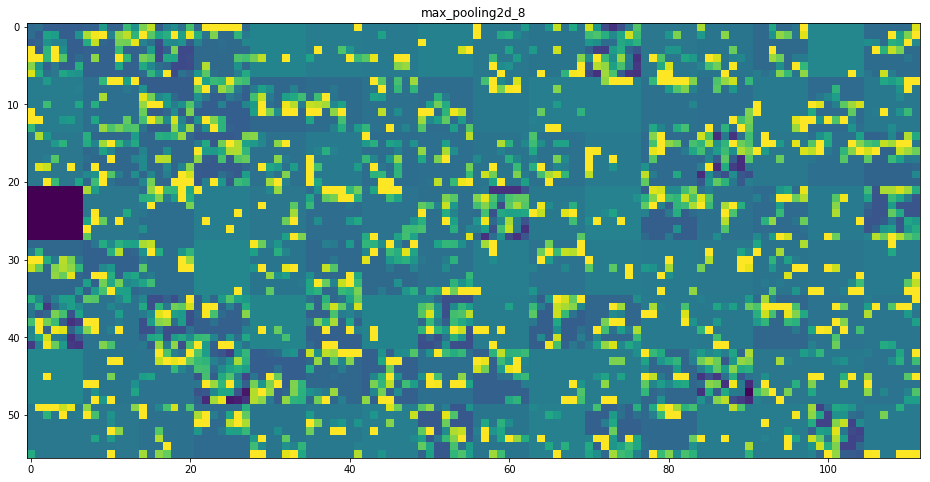

In [11]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))

    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [1]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
    include_top=False)

Q:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [11]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def deprocess_image2(x):
    #x -= x.mean()
    #x /= (x.std() + 1e-5)
    #x *= 0.1
    
    #x += 0.5
    #x = np.clip(x, 0, 1)
    
    #x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [36]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.ones((1, size, size, 3))*255#np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1
    for i in range(200):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return [deprocess_image(img.copy()), deprocess_image2(img.copy())]

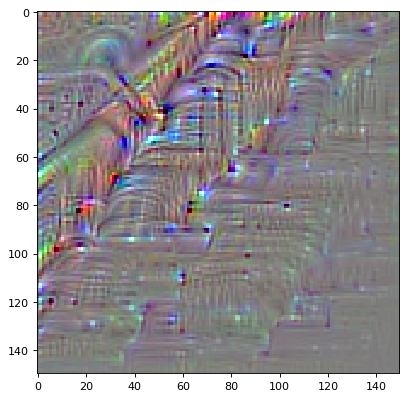

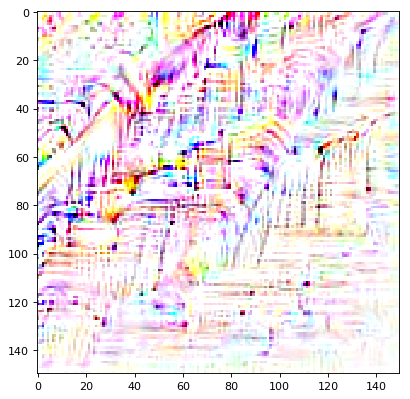

In [37]:
import matplotlib.pyplot as plt
import numpy as np

layer_name = 'block5_pool'
filter_num = 55

plt.figure(num=None, figsize=(6, 6), dpi=80)
plt.imshow(generate_pattern(layer_name, filter_num)[0])

plt.figure(num=None, figsize=(6, 6), dpi=80)
plt.imshow(generate_pattern(layer_name, filter_num)[1])

plt.show()

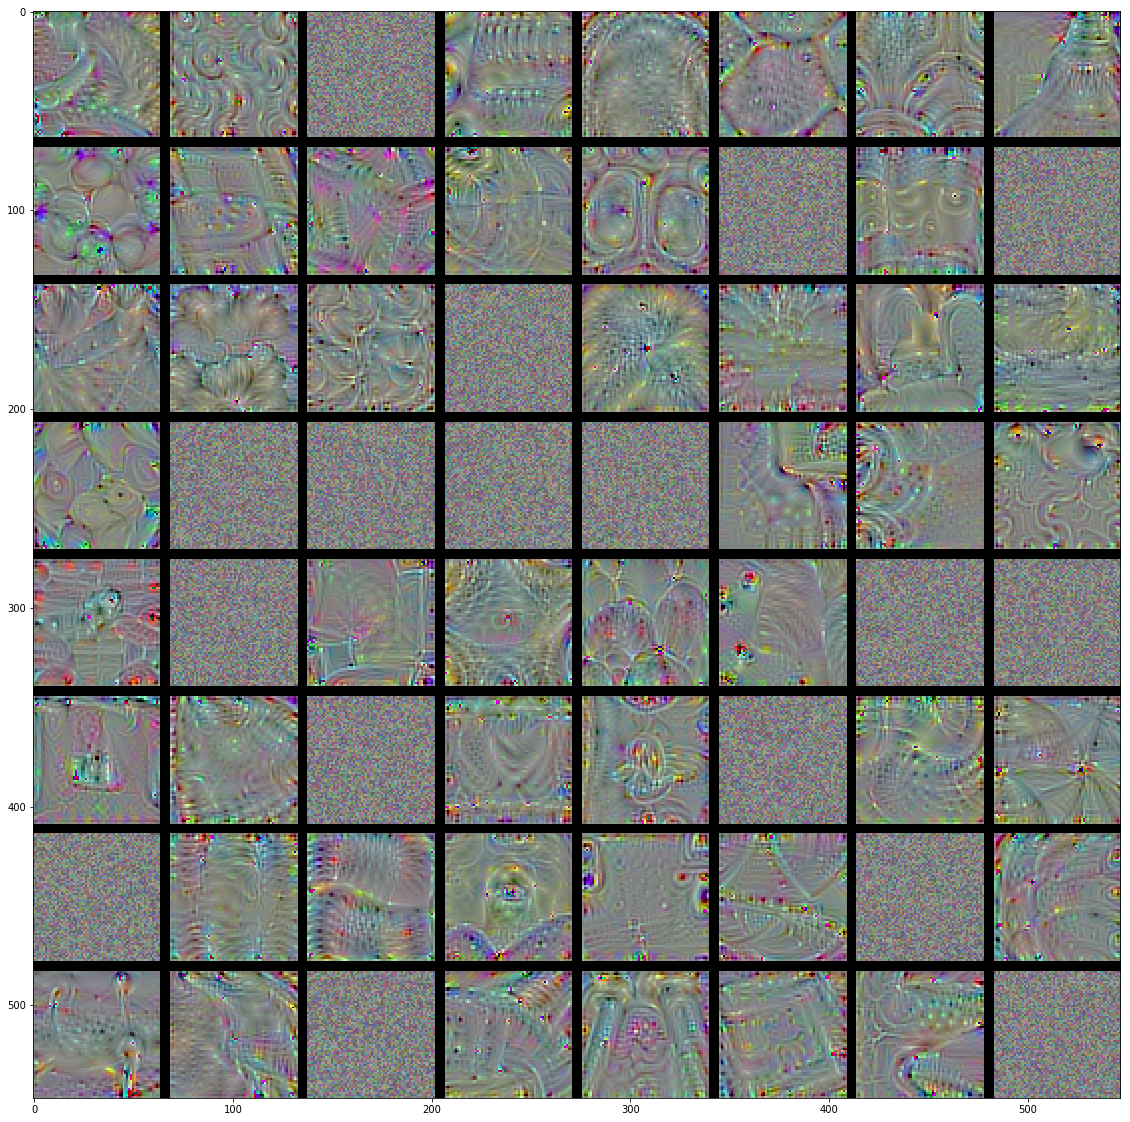

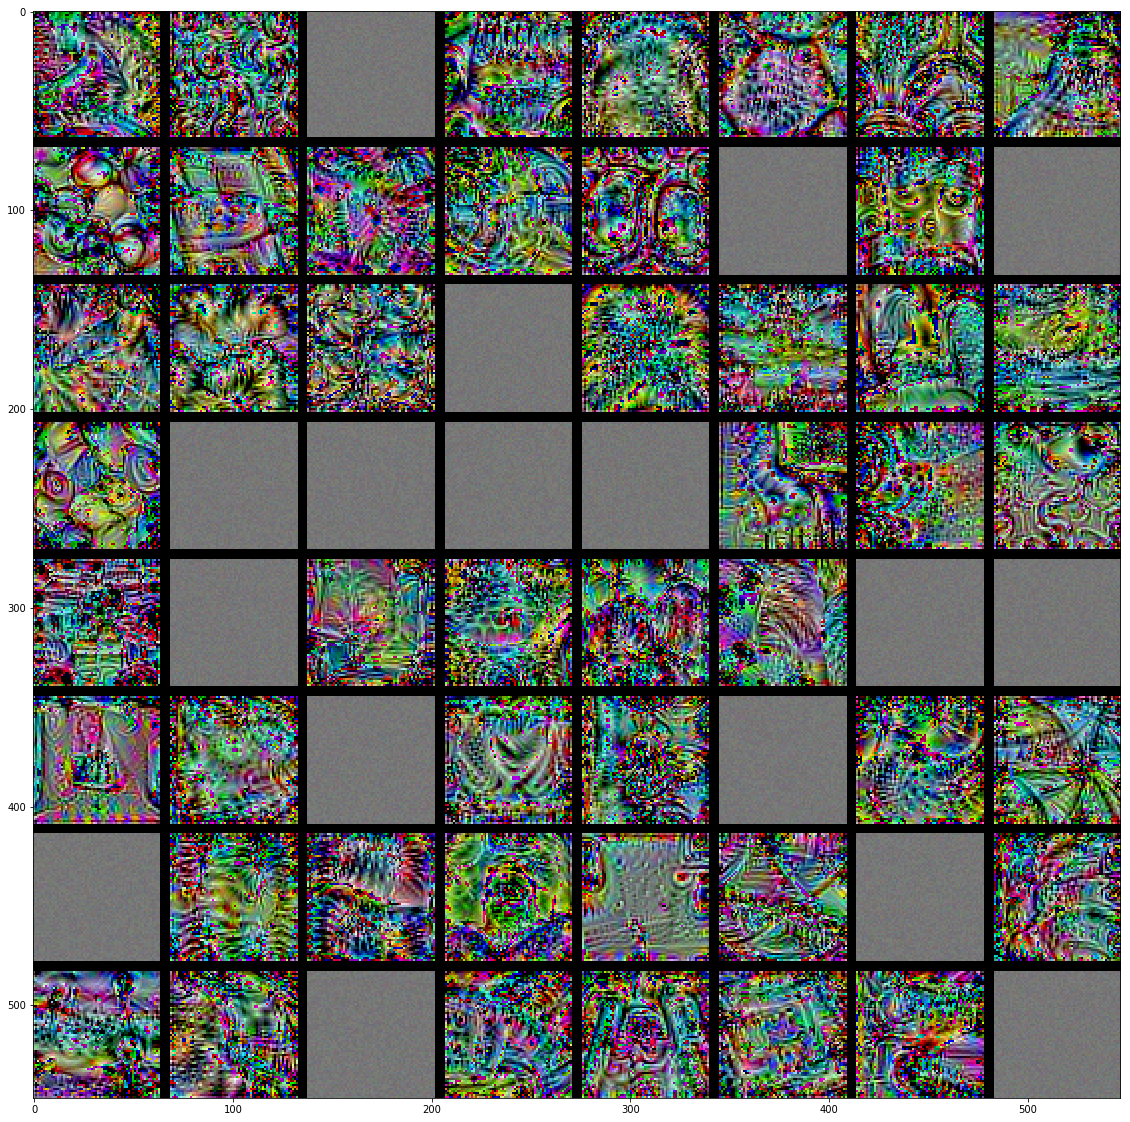

In [19]:
layer_name = 'block5_conv1'
size = 64
margin = 5

results = np.zeros((8 * size+7* margin, 8 * size+7* margin, 3))
results2 = np.zeros((8 * size+7* margin, 8 * size+7* margin, 3))

for i in range(8):
    for j in range(8):
        filter_img, filter_img2 = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
            vertical_start: vertical_end, :] = filter_img
        results2[horizontal_start: horizontal_end,
            vertical_start: vertical_end, :] = filter_img2

plt.figure(figsize=(20, 20))
plt.imshow(results)
plt.figure(figsize=(20, 20))
plt.imshow(results2)

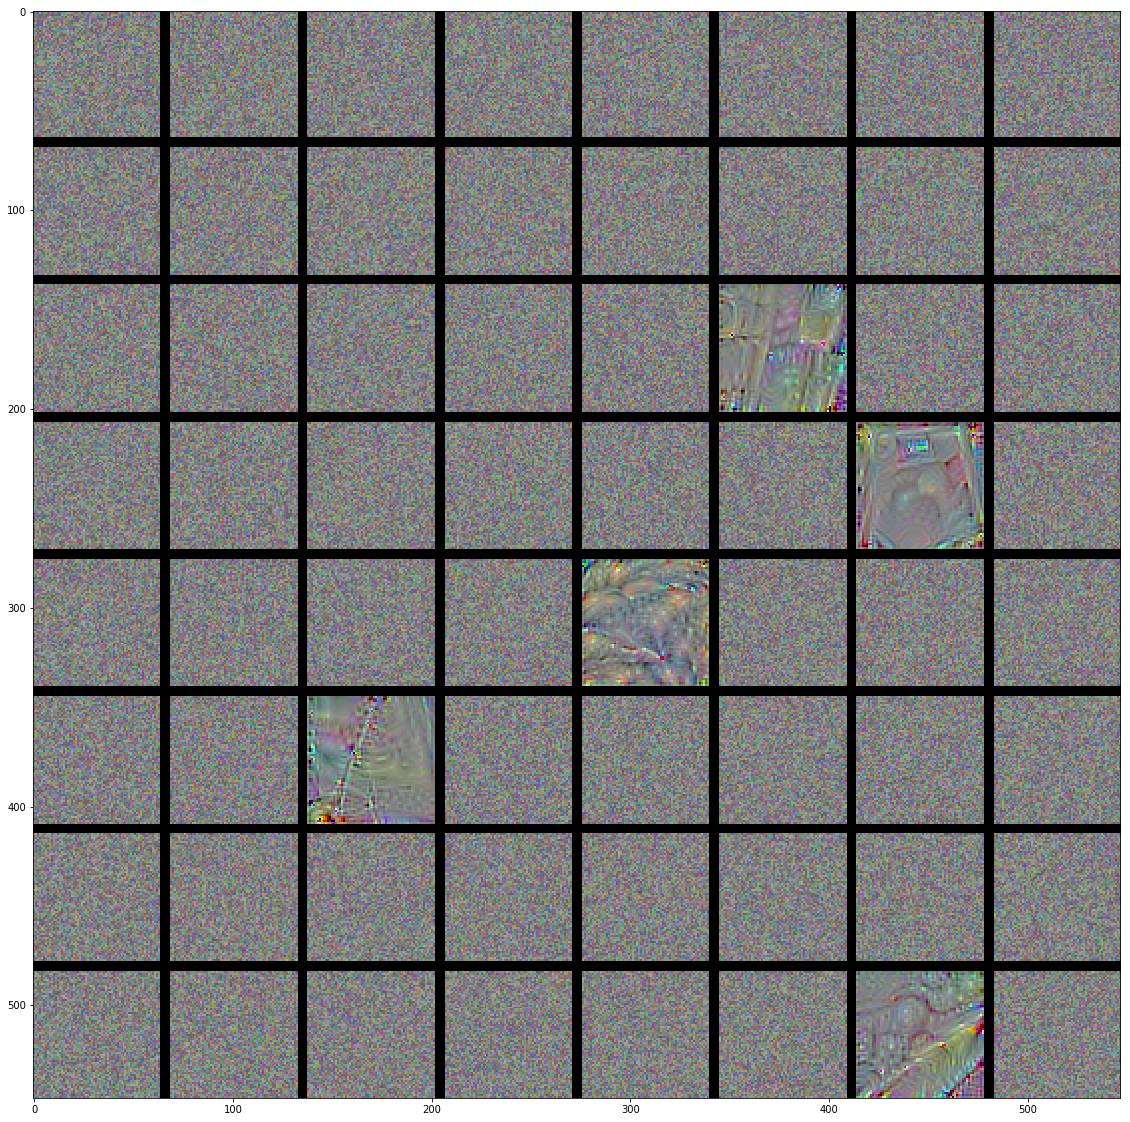

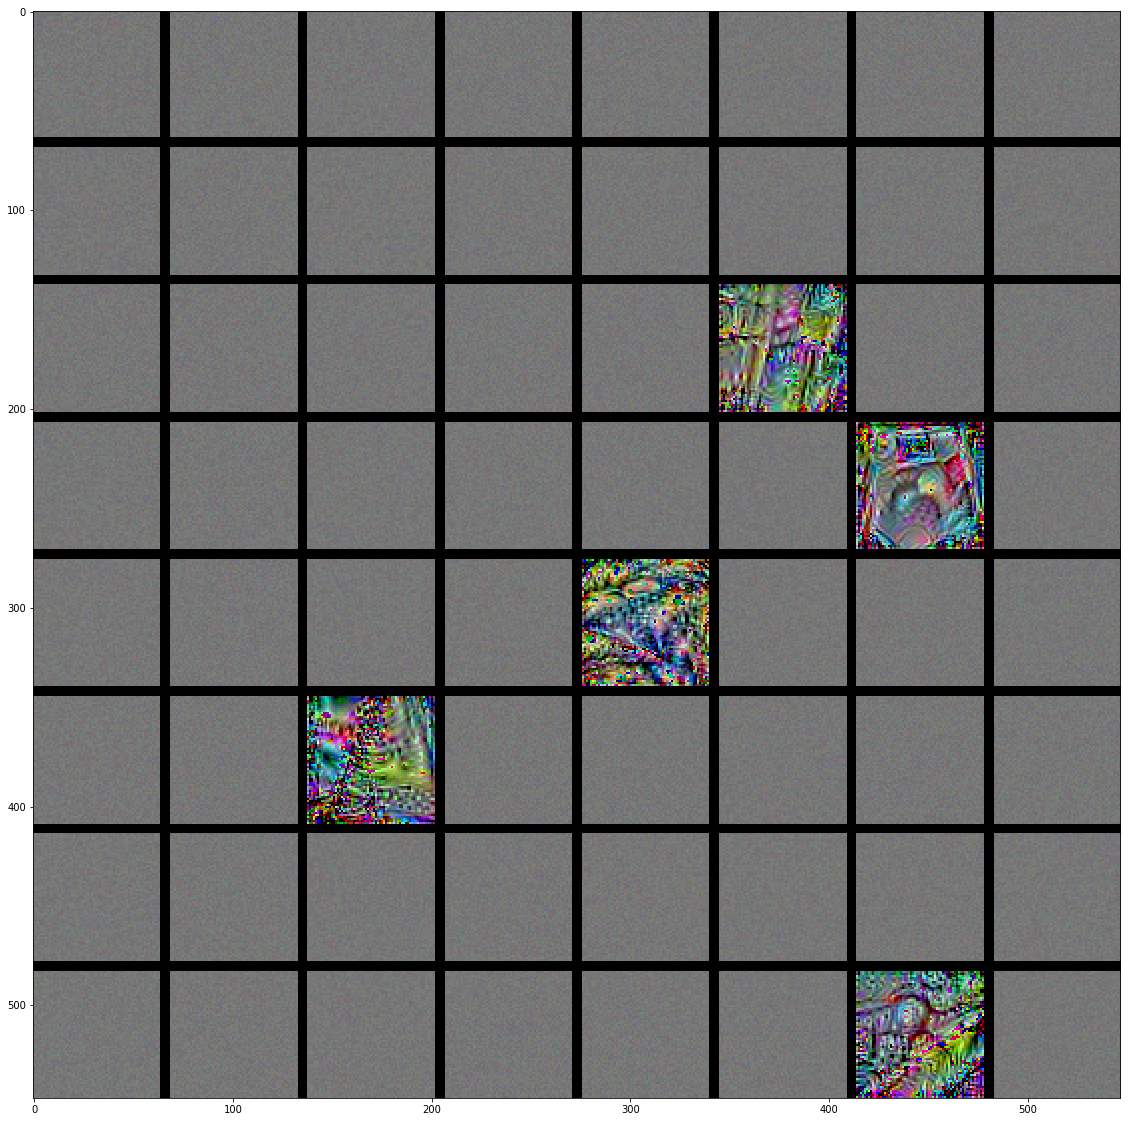

In [20]:
layer_name = 'block5_pool'
size = 64
margin = 5

results = np.zeros((8 * size+7* margin, 8 * size+7* margin, 3))
results2 = np.zeros((8 * size+7* margin, 8 * size+7* margin, 3))

for i in range(8):
    for j in range(8):
        filter_img, filter_img2 = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
            vertical_start: vertical_end, :] = filter_img
        results2[horizontal_start: horizontal_end,
            vertical_start: vertical_end, :] = filter_img2

plt.figure(figsize=(20, 20))
plt.imshow(results)
plt.figure(figsize=(20, 20))
plt.imshow(results2)

# Trying deepdream

In [ ]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
    include_top=True)

model